# Tutorial Vegetation Indices with **AgriSatPy**

## Learning Objectives

In this notebook you will learn how to

* load data from a bandstacked geoTiff
* load data from a Sentinel-2 scene organized in the .SAFE folder structure
* calculate some basic vegetation indices (e.g., NDVI) for a region of interest
* plot derived vegetation indices

## Pre-Requisites

This tutorial is introductorial level. You should know, however, about the concept of vegetation indices (VIs). If you do not feel confident about VIs yet, have a look at this [free tutorial by EO4GEO](http://www.eo4geo.eu/training/sentinel-2-data-and-vegetation-indices/).

To run this notebook no additional requirements in terms of software-setup are necessary.

The data required to run this notebook can be found [here](./../data).

### I) Load Data from Band-Stacked Sentinel-2 geoTiff File and calculate the NDVI for a List of Field Parcels

Here, we will load a geoTiff file containing Sentinel-2 bands already resampled to 10m spatial resolution using AgriSatPys spatial resampling module. We will then calculate the `Normalized Difference Vegetation Index` (NDVI) and plot it.

In [1]:
# load required modules
from pathlib import Path
from agrisatpy.utils.io.sentinel2 import S2_Band_Reader
from agrisatpy.analysis.vegetation_indices import VegetationIndices

In [2]:
# define input data paths
fpath_bandstack = Path('./../data/20190530_T32TMT_MSIL2A_S2A_pixel_division_10m.tiff')
fpath_field_parcels = Path('./../data/sample_polygons/ZH_Polygons_2020_ESCH_EPSG32632.shp')

#### I.1) Reading the Data
In the first step, we read data from geoTiff file (*`fpath_bandstack`* ) using the S2_Band_Reader. The shapefile (*`fpath_field_parcels`* ) specified contains a number of agricultural field parcels. The reader is designed in a way that it only reads the data covering the field polygons using numpy's MaskedArray.

To ensure easy access the data is stored in a dictionary (*`reader.data`* ) whose keys correspond to **Sentinel-2 bands mapped to color-names**. Mapping bands to colornames instead of numbering them, e.g. `B02`, `B03` etc., allows for a more generic data handling and is usually easier for humans to rememeber than a list of abstract numbers.

In [3]:
# get reader object
reader = S2_Band_Reader()
reader.read_from_bandstack(
    fname_bandstack=fpath_bandstack,
    in_file_aoi=fpath_field_parcels
)
# check the reader.data dict with the read data
reader.data.keys()

dict_keys(['blue', 'green', 'red', 'red_edge_1', 'red_edge_2', 'red_edge_3', 'nir_1', 'nir_2', 'swir_1', 'swir_2', 'meta', 'bounds'])

**Spatial resampling** is not required here, since all bands already have the same spatial resolution of 10m. We can check the `meta` information to get the geo-localization of read from the geoTiff file. To do so, we need to access the *`reader.data`* dictionary where all the band data and meta-data is available:

In [4]:
reader.data['meta']

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 221,
 'height': 294,
 'count': 10,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 475420.0,
        0.0, -10.0, 5256840.0)}

Additionally, the `bounding box` is provided in image coordinates (i.e., UTM). We can access the bounding box using the *`bounds`* item:

In [5]:
reader.data['bounds']

BoundingBox(left=475420.0, bottom=5253900.0, right=477630.0, top=5256840.0)

To get an overview, AgriSatPy offers built-in support for true and false color RGB plots:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


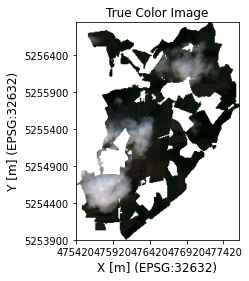

In [6]:
# true color RGB
fig_rgb = reader.plot_rgb()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


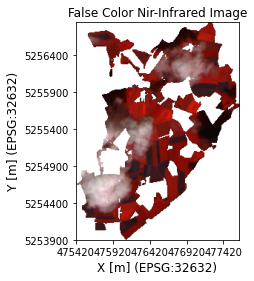

In [7]:
# false color Infrared
fig_nir = reader.plot_false_color_infrared()

Next, we can select one band, e.g., `blue` and plot it:

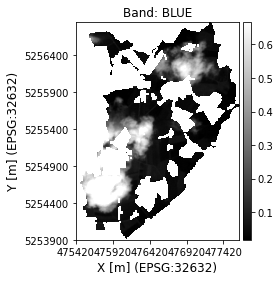

In [8]:
%matplotlib inline
fig_blue = reader.plot_band('blue')

#### I.2) Calculating the NDVI

Using the `red` and `nir_1` band we can then plot the NDVI. Since we use the colornames instead of sensor-specific band names, this works theoretically for any sensor having a red and near-infrared band.

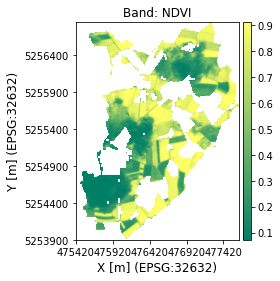

In [9]:
# we need an object from the VegetationIndices class. It takes the reader object as argument.
vi_s2 = VegetationIndices(reader=reader)

# name is not case-sensitive but it must be consistent
vi_name = 'NDVI'
# then we are ready to calculate the NDVI
ndvi = vi_s2.calc_vi(vi_name)

# add to reader as new band
reader.add_band(band_name=vi_name, band_data=ndvi)

# plot the NDVI. The method automatically selects the correct bands based on their colorname from the data dict
fig_ndvi = reader.plot_band(band_name=vi_name, colormap='summer')

#### I.3) Calculating the NDVI for the entire region covered by the field parcels

In some cases, it might be interesting to have a look at the entire area encompassing the field parcel polygons. The reader class also supports the processing of the entire area encompassing the field parcel geometries specified.

The only thing that is different from the previous steps is the usage of an additional keyword when reading the data:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


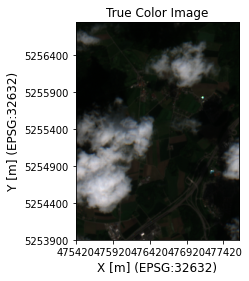

In [10]:
reader = S2_Band_Reader()
reader.read_from_bandstack(
    fname_bandstack=fpath_bandstack,
    in_file_aoi=fpath_field_parcels,
    full_bounding_box_only=True  # set this flag to True 
)

vi_s2 = VegetationIndices(reader=reader)

fig_rgb = reader.plot_rgb()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


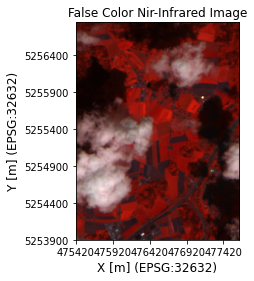

In [11]:
fig_nir = reader.plot_false_color_infrared()

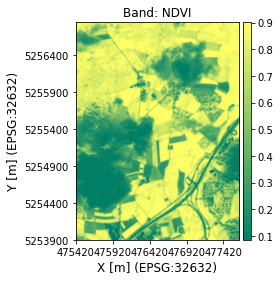

In [12]:
# name is not case-sensitive but it must be consistent
vi_name = 'NDVI'
# then we are ready to calculate the NDVI
ndvi = vi_s2.calc_vi(vi_name)

# add to reader as new band
reader.add_band(band_name=vi_name, band_data=ndvi)

# plot the NDVI. The method automatically selects the correct bands based on their colorname from the data dict
fig_ndvi = reader.plot_band(band_name=vi_name, colormap='summer')